# **<h1><center> K-Means Rock Type Clustering </center></h1>**

#### **Description:** 
- K-means clustering is used to discover primary rock types in a deep well drilled in the Williston Basin. The project begins by identifying primary rock types for a large section of rock spanning roughly 9,000’, then focuses on a smaller section of rock (~60’) to identify distinct strata in a reservoir. Two unique models are built, however the process is only covered one time as the only difference is the amount of data fed into the model.

#### **Data Context:**
- Operators drilling for oil and gas want to understand the subsurface reservoirs that they are trying to produce from, and one of the most common ways of doing so is by “logging” a well. A well is drilled vertically to some depth, and a tool is run inside the hole with sensors and measurements are taken. From these measurements, we infer properties about the rock that cannot be measured directly such as porosity, permeability, and oil saturation. Different rock types such as sandstones, limestones, and claystones have distinctly different readings on these tools. Here I hope to provide a very high level overview of some of the common logs.

1) Gamma Ray (GR): Measures the natural radioactivity of the rock
2) Density (RHOZ): Measures electron density, which is closely tied to bulk density
3) Neutron (NPHI): Measures the hydrogen content of the formation which is related to its porosity and/or mineralogy

#### **Machine Learning: What is K-Means Clustering? Why Bother?**
- K-Means clustering is an unsupervised learning algorithm that attempts to uncover structures within the dataset it is provided. In one sentence: the algorithm will cross plot all of our variables against each other and see if there are any homogenous groups (clusters) in which the points can then be categorized. In the context of this project, we will be looking to see if different rock types are discernable with this methodology. This is something that petrophysicists have been doing for decades manually and has proven incredibly valuable. Why use machine learning instead of doing this manually?

1) Time: This process can be done for thousands of wells, millions of rows of data, in a matter of minutes. This type of project would take weeks if not months of concentrated effort traditionally.

2) Bias: It is repeatable, the subjectivity of the interpreter is minimized. There is still room for interpretation however it is bounded and the logic more tenable.

3) Exploration: In many cases, the algorithm will find relationships that we didn’t know existed but make sense in a physical space and can be very valuable once we are aware of them. It important to remember we don’t have it all figured out and remain open to new ideas and learning something.

### Import dependencies

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
pd.set_option('display.float_format', '{:.2f}'.format)
import numpy as np
import plotly
import plotly.express as px
import lasio
import matplotlib.pyplot as plt
print("Done")

Done


### Create DataFrame from .las files
- We won’t be using 55 logs in our analysis, as most of them are either irrelevant for this study or are highly correlated with another log (providing no unique information and a increasing dimensionality). We can achieve good results with the 3 most fundamental logs (GR, RHOZ, NPHI). The RHOZ log is trimmed to reasonable values, and fortunately this removes all the other suspect data as it occurs over the same interval. We are also dropping the first 2000’ of data as it covers a homogenous unit and is simply not interesting for this project.

In [2]:
# Import .las file into a LASFile object (from lasio package)
las = lasio.read(r"well_log.las")

# Create DataFrame
df = las.df()

# Observe DataFrame
print(df.shape)
df.head()

(21543, 55)


,AF10,AF20,AF30,AF60,AF90,AO10,AO20,AO30,AO60,AO90,...,RSOZ,RWA_HILT,RXO8,RXOZ,SP,SPAR,STIT,TENS,TNPH,HTNP_SAN
DEPT,,,,,,,,,,,,,,,,,,,,,
7.00,0.90,5.97,111.83,11.37,9.71,0.18,0.55,2.67,2.32,2.23,...,NaN,2.36,NaN,NaN,-459.00,-459.00,0.00,1054.00,-0.07,-0.06
7.50,0.90,5.97,111.83,11.37,9.71,0.18,0.55,2.67,2.32,2.23,...,NaN,2.36,NaN,NaN,-459.00,-459.00,0.00,1054.00,-0.07,-0.06
8.00,0.90,5.97,111.83,11.37,9.71,0.18,0.55,2.67,2.32,2.23,...,NaN,2.36,NaN,NaN,-459.00,-459.00,0.00,1054.00,-0.06,-0.06
8.50,0.90,5.97,111.83,11.37,9.71,0.18,0.55,2.67,2.32,2.23,...,NaN,2.36,NaN,NaN,-459.00,-459.00,0.00,1054.00,-0.06,-0.06
9.00,0.90,5.97,111.83,11.37,9.71,0.18,0.55,2.67,2.32,2.23,...,NaN,2.36,NaN,NaN,-459.00,-459.00,0.00,1054.00,-0.06,-0.06


### View avaliable logs

In [3]:
# Create a copy to manipulate
df_tc = df.copy()

# Filter to the logs we need and reasonable values
df_tc = df_tc[['GR','RHOZ','NPHI']]
df_tc = df_tc[df_tc['RHOZ'].between(1.8,3.2)]

# Drop first 2000'
df_tc = df_tc[df_tc.index > 2000]

# Drop rows missing values
df_tc.dropna(inplace=True)

# Inspect
print(df_tc.shape)
df_tc.describe().transpose()

(17504, 3)


,count,mean,std,min,25%,50%,75%,max
GR,17504.00,73.08,66.39,3.92,22.49,75.86,100.44,1217.80
RHOZ,17504.00,2.56,0.19,1.83,2.41,2.57,2.71,3.17
NPHI,17504.00,0.18,0.15,-0.02,0.03,0.16,0.33,0.60


# Log Plot
- We will use MatPlotLib here to create a log plot with two tracks. The first has our Gamma Ray log that has been shaded to highlight variability. The second track contains the NPHI & RHOZ logs. They have been placed on the same track and their relationship with one another has been shaded (a common petrophysical technique)

### Define Plotting Function

In [4]:
def makeplot(well_df, top_depth, bottom_depth):
    fig, ax = plt.subplots(figsize=(12,9))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,5), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,5), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = ax2.twiny() #Twins the y-axis for the density track with the neutron track
 

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot(well_df["GR"], well_df.index, color = "black", linewidth = 0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("black")
    ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")
    ax1.title.set_color('black')
    ax1.set_xticks([0, 50, 100, 150, 200])
    
    left_col_value = 0
    right_col_value = 200
    span = abs(left_col_value - right_col_value)

    cmap = plt.get_cmap('inferno_r')
    color_index = np.arange(left_col_value, right_col_value, span / 5)

    #loop through each value in the color_index
    for index in sorted(color_index):
        index_value = (index - left_col_value)/span
        color = cmap(index_value) #obtain colour for color index value
        ax1.fill_betweenx(well_df.index, well_df["GR"] , 200, where = well_df["GR"] >= index,  color = color)


    # Density track
    ax2.plot(well_df["RHOZ"], well_df.index, color = "green", linewidth = 0.5)
    ax2.set_xlabel("Density")
    ax2.set_xlim(1.95, 2.95)
    ax2.xaxis.label.set_color("green")
    ax2.tick_params(axis='x', colors="green")
    ax2.spines["top"].set_edgecolor("green")
    ax2.set_xticks([1.95, 2.45, 2.95])

    # Neutron track placed ontop of density track
    ax3.plot(well_df["NPHI"], well_df.index, color = "blue", linewidth = 0.5)
    ax3.set_xlabel('Neutron')
    ax3.xaxis.label.set_color("blue")
    ax3.set_xlim(0.4, -0.1)
    ax3.tick_params(axis='x', colors="blue")
    ax3.spines["top"].set_position(("axes", 1.08))
    ax3.spines["top"].set_visible(True)
    ax3.spines["top"].set_edgecolor("blue")
    ax3.set_xticks([0.4,  0.1, -0.1])
    
    x1=well_df['RHOZ']
    x2=well_df['NPHI']

    x = np.array(ax2.get_xlim())
    z = np.array(ax3.get_xlim())

    nz=((x2-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)

    ax2.fill_betweenx(well_df.index, x1, nz, where=x1>=nz, interpolate=True, color='lightgrey')
    ax2.fill_betweenx(well_df.index, x1, nz, where=x1<=nz, interpolate=True, color='yellow')

    
    if any("Cluster" in s for s in well_df.columns.tolist()):
        log = [l for l in well_df.columns.tolist() if "Cluster" in l][0]
        str(log)
        ax4 = plt.subplot2grid((1,5), (0,2), rowspan=1, colspan = 1, sharey = ax1)
        ax15 = ax4.twiny()
        ax15.xaxis.set_visible(False)

        # Lithology track
        ax4.plot(well_df[log], well_df.index, color = "black", linewidth = 0.5)
        ax4.set_xlabel("Lithology")
        ax4.set_xlim(0, 1)
        ax4.xaxis.label.set_color("black")
        ax4.tick_params(axis='x', colors="black")
        ax4.spines["top"].set_edgecolor("black")

        for key in cluster_color_dict.keys():
            color = cluster_color_dict[key]['color']
            ax4.fill_betweenx(well_df.index, 0, well_df[log], where=(well_df[log]==key),
                             facecolor=color)


        ax4.set_xticks([0, 1])
        
        ax4.set_ylim(bottom_depth, top_depth)
        ax4.grid(which='major', color='lightgrey', linestyle='-')
        ax4.xaxis.set_ticks_position("top")
        ax4.xaxis.set_label_position("top")
        ax4.spines["top"].set_position(("axes", 1.02))
        
        
        plt.setp(ax4.get_yticklabels(), visible = False)


    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
        
    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.25)

## Create Plot

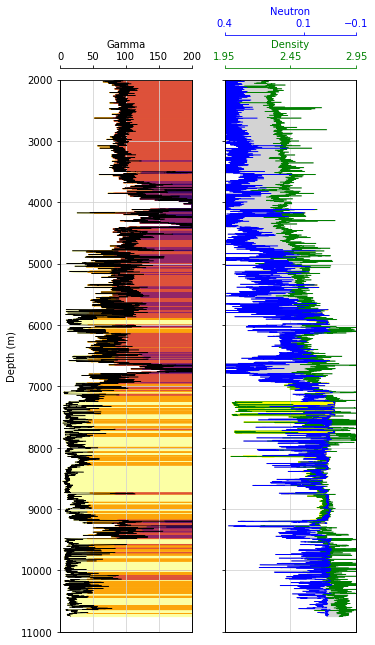

In [5]:
makeplot(df_tc,2000,11000)

### Standardize Data
- We need to scale our data so that they have similar variances. Think about cross plotting two variables with wildly different scales, it can be very hard to visualize. Our clustering algorithm will want to make these clusters more/less circular in cross plot space, so if the variance among our features are materially different this will lead to the variables with smaller variance getting more weight/being more influential. Our variances here are not terribly different, but it never hurts to standardize and is considered good practice.

- Scikit-Learn’s StandardScaler will transform our distributions to have a mean of 0 and a standard deviation of 1.

In [17]:
from sklearn.preprocessing import StandardScaler

# Create the scaler and standardize the data
scaler = StandardScaler()
df_tc_nrm = scaler.fit_transform(df_tc)

# Create DataFrame
df_tc_nrm = pd.DataFrame(df_tc_nrm, columns = df_tc.columns, index = df_tc.index)

# Inspect
print(df_tc_nrm.shape)
df_tc_nrm.describe().transpose()

(17504, 3)


,count,mean,std,min,25%,50%,75%,max
GR,17504.00,-0.00,1.00,-1.04,-0.76,0.04,0.41,17.24
RHOZ,17504.00,0.00,1.00,-3.90,-0.82,0.05,0.76,3.23
NPHI,17504.00,-0.00,1.00,-1.38,-1.03,-0.13,1.01,2.84


## Build Model
- We create our model and specify how many clusters we want to create. There are methods to determine how many clusters we should look for, however when working with mixed mediums like rocks the decision is rarely easily determined. I have found it best to take an iterative approach and err on the side of too many clusters. If we have too many clusters we can always combine some together. If we have too few we may not identify an important rock type. We can also specify other hyperparameters at this time, but the defaults meet our needs in this case.

In [18]:
# Create model
cluster_model = KMeans(n_clusters = 6)

# Fit to our DataFrame
cluster_model.fit(df_tc_nrm)

# Create new dataframes to hold our cluster results
df_tc_cluster = df_tc.copy() 
df_tc_nrm_cluster = df_tc_nrm.copy()

# Get the cluster labels into our standardized and non-standardized DataFrames for visualization
df_tc_cluster['Clusters'] = cluster_model.labels_ + 1
df_tc_nrm_cluster['Clusters'] = cluster_model.labels_ + 1

## View Clusters - 2D Scatter

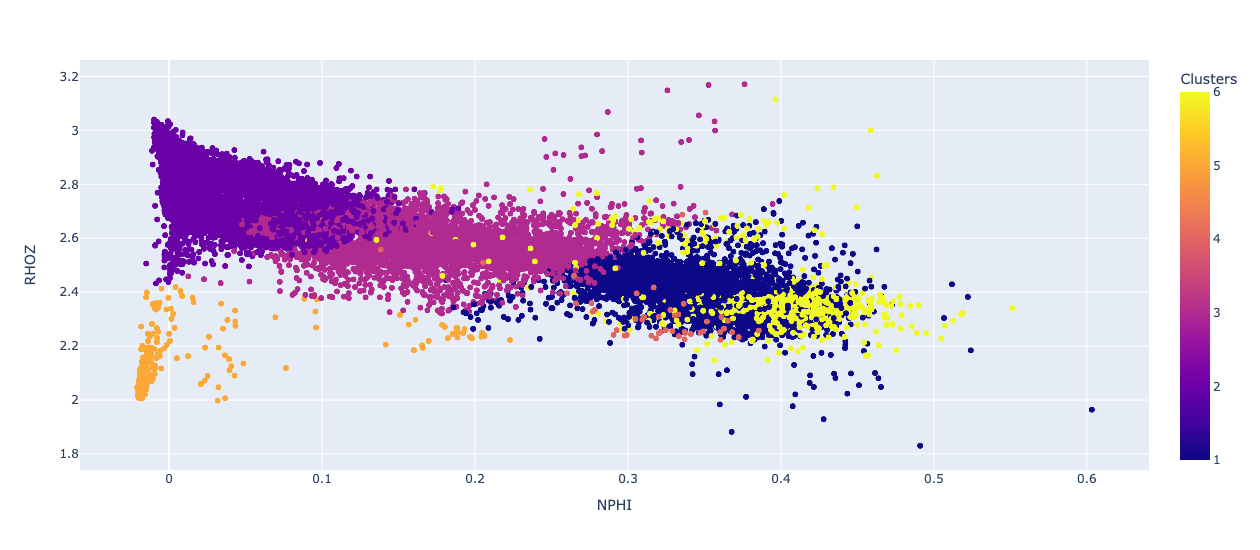

In [19]:
fig = px.scatter(df_tc_cluster, y='RHOZ', x='NPHI', color = 'Clusters', width=900, height=550)

fig.show()

## View Clusters - 3D Scatter

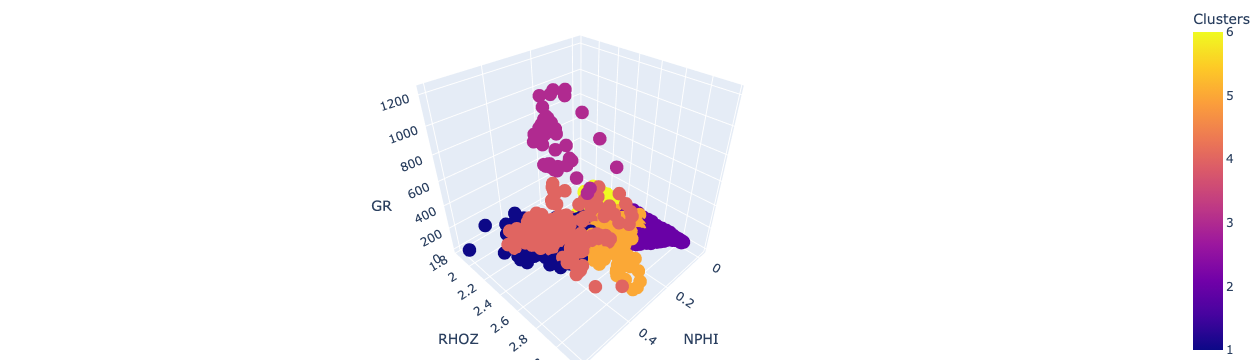

In [9]:
fig = px.scatter_3d(df_tc_cluster, 
                    x='NPHI', 
                    y='RHOZ', 
                    z='GR',
                    color='Clusters')

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

## View Clusters - Log Plot

### Cluster Color Dictionary

In [20]:
cluster_color_dict = {
    1: {'color':'fuchsia'},
    2: {'color':'orange'},
    3: {'color':'CornflowerBlue'},
    4: {'color':'black'},
    5: {'color':'green'},
    6: {'color':'yellow'},
     }  

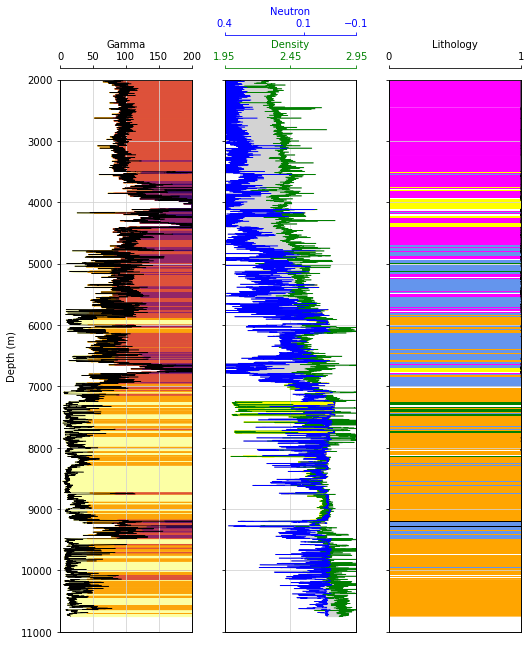

In [21]:
makeplot(df_tc_cluster,2000,11000)

## Interpretation:
- Zooming in on the pink colored clusters, we can see that they have very low gamma readings, and our density log (green) is reading very low. This is a common response of salt; these are salt beds and they cause a host of issues for operators all around the world. One of which we can see here, note how our green RHOB log appears to read erratically around these beds, this is due to poor borehole conditions caused by these salts.

- Salt can also lead to well integrity issues and can cause a well to fail which is not only costly to fix but also halts any production from that well. Identifying these layers and mapping them can help operators plan for special casing designs over these intervals, possibly saving millions in future remediation.

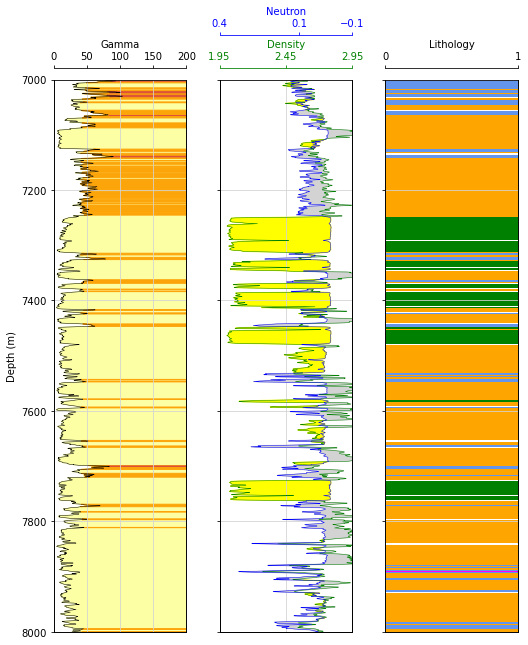

In [22]:
makeplot(df_tc_cluster,7000,8000)

- Moving further down section to the primary formation of interest in the basin (Bakken formation), we see some interesting trends. This is the only section of the entire well in which we see this cluster represented by the color black. These are the upper and lower bakken shales, and they are the primary source for the oil in the bakken petroleum system. The blue cluster is interpreted to be carbonate rock, which has little to no porosity and does not hold notable oil. The yellow cluster defines the primary reservoirs for the petroleum system, which are filled with hydrocarbons and have produced hundreds of millions of barrels of oil.



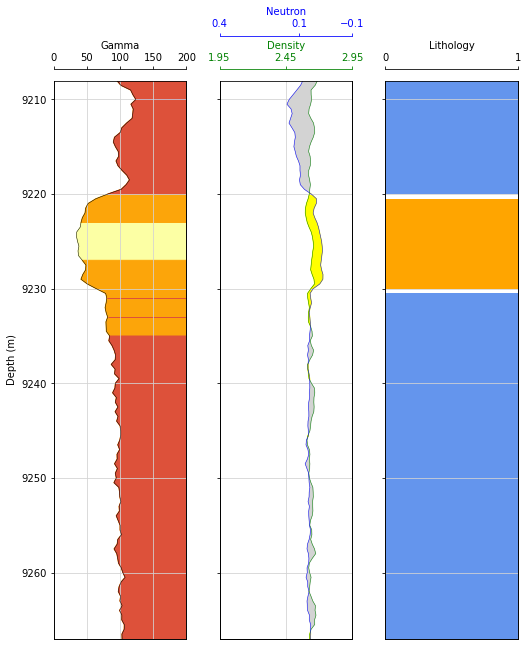

In [23]:
#makeplot(df_plot,9100,9600)
makeplot(df_tc_cluster,9208,9267)

## Getting Granular:
- It can be valuable to identify the primary rock types for the entire basin using a clustering algorithm on the entire section of rock as detailed above, but sometimes we want to get specific. Another use of this tool is to limit our section of rock to a single interval and generate clusters to parse out this formation into smaller units for classification/ranking. In this example I will zoom in on the Middle Bakken reservoir, which is the most prolific formation in the Williston Basin.



In [31]:
df_tc_nrm_bakken = df_tc_nrm.copy()
df_tc_nrm_bakken = df_tc_nrm_bakken.loc[9208:9267,:]
df_tc_bakken = df_tc.copy()
df_tc_bakken = df_tc_bakken.loc[9208:9267,:]

# Create model
cluster_model_bakken = KMeans(n_clusters = 6)

# Fit to our DataFrame
cluster_model_bakken.fit(df_tc_nrm_bakken)

# Create new dataframes to hold our cluster results
df_tc_bakken_cluster = df_tc_bakken.copy() 
df_tc_nrm_bakken_cluster = df_tc_nrm_bakken.copy()

# Get the cluster labels into our standardized and non-standardized DataFrames
df_tc_bakken_cluster['Clusters_bakken'] = cluster_model_bakken.labels_ + 1
df_tc_nrm_bakken_cluster['Clusters_bakken'] = cluster_model_bakken.labels_ + 1

- If we were to limit our DataFrame and create a new clustering model on just this small subset of data, we would return what is shown below.

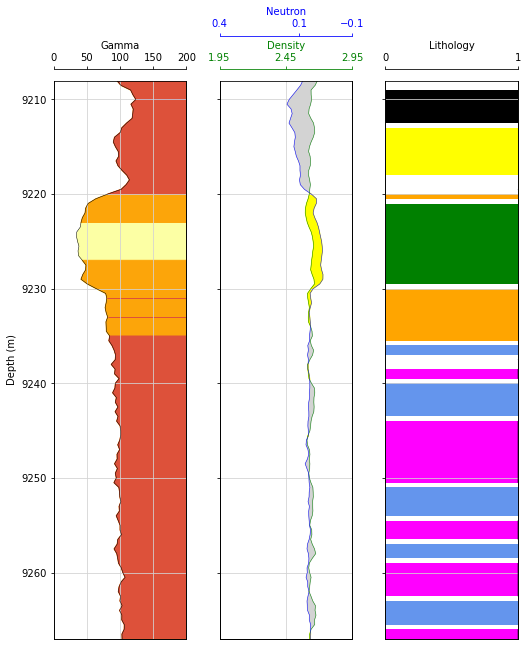

In [32]:
makeplot(df_tc_bakken_cluster,9208,9267)

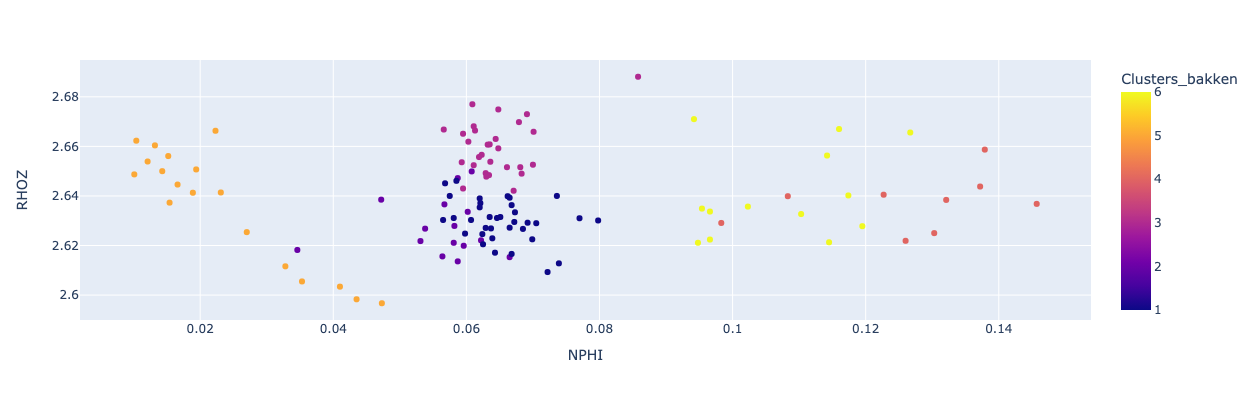

In [42]:
fig = px.scatter(df_tc_bakken_cluster, 
                 y='RHOZ', 
                 x='NPHI', 
                 color = 'Clusters_bakken', 
                 width=700, 
                 height=400)

fig.show()

- This is a good example of possibly using too many clusters, in which the interpreter could then combine them! I would interpret the pink and green clusters to both represent a dolomitic rock type, while the yellow and blue clusters represent a less favorable carbonate layer. The orange and black clusters might remain separate clusters, as the orange appears to have slightly lower density, which could be a function of the mineralogy or the porosity (either way it is systematically different).

- This can be incredibly valuable, because different rock types have different reservoir characteristics and lead to differential oil production. Knowing that in one area of the basin we see a large amount of the favorable pink/green cluster (dolomite), we would expect to see better performance here than in another area that is dominated by the carbonate bed (yellow/blue).



### Expansion / Future Work:
- This final approach to using this tool that I would like to briefly touch on is building a model using data from the just the Middle Bakken formation, using data from multiple wells.

- Why would that be valuable?

    - Building a k-means model with data for one well, using 6 clusters, means that 6 groups will be identified in this well (all clusters will be present)
        - What if there are unique rock types in different parts of the basin, seen in some wells and not in others? Our previously created model will not uniquely identify them and just know to add a new cluster, they will be shoehorned into one of the existing cluster groups
    - Building a model using the data from multiple wells, allows for the identification of all unique groups. We would them use this master model to predict the clusters for each individual well. Some wells may in fact contain all 6 clusters, while others are more homogenous and only have 2-3.
    - Mapping the data spatially allows us to see where some rock types thicken, thin, or completely disappear which can be incredibly valuable when comparing two different areas from a business development perspective.